# Feature Extraction at Time Series Level for Clustering Nights
The following assumes that we have now selected a set of candidates where the night periods have been preprocessed to ensure that they are consistent and complete, with a consistent start and end time and candidates have been selected based broadly that they maximise the number of complete nights (determined by having zero missing intervals). Generating these features will provide the ability to look at the night periods as a whole, rather than individual intervals, and to cluster them based on their features. This is useful for clustering analysis, where we want to group similar nights together based on their features. The desire is to find patterns in the night periods that can be used to identify different types of nights, such as restful nights, restless nights, or nights with specific patterns of activity. This can help to identify different types of sleep disturbances or other activity that has an impact on the night period, and to provide insights into the underlying states of the patients during these periods.

In [171]:
from stumpy.core import rolling_window
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import time
import matplotlib.pyplot as plt
import seaborn as sns

from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering
from src.sample_filter import SampleFilter
from src.time_series_analysis import plot_night_time_series

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 1
iob_nan_min = 1
bg_nan_min = 1
sample = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample.get_consolidated_df()
sample.return_counts()

2025-06-30 12:46:45.253 | INFO     | src.nights:_calculate_overall_stats:11 - No stats per night have been calculated for 67167655. Returning no output.
Number of nights objects created: 83
2025-06-30 12:46:59.965 | INFO     | src.sample_filter:return_counts:131 - For sample rate of 30 minutes:
  min_nights=30
  missed_intervals=1
2025-06-30 12:46:59.965 | INFO     | src.sample_filter:return_counts:134 - Number of candidates: 17
2025-06-30 12:46:59.965 | INFO     | src.sample_filter:return_counts:135 - Number of nights: 965


(17, 965)

In [77]:
nan_counts = df.isna().sum()
print("Total NaNs per column:")
print(nan_counts)

Total NaNs per column:
iob mean                0
cob mean             1405
bg mean                 0
iob min                 0
cob min              1405
bg min                  0
iob max                 0
cob max              1405
bg max                  0
iob std              4367
cob std              5548
bg std               4367
iob count               0
cob count               0
bg count                0
offset                  0
day                     0
time                    0
night_start_date    34267
dtype: int64


There is an oddly significant jump in the number of NaNs in the 'cob mean' column, which is likely due to the way that the COB data is collected and processed. This is a good indication that we need to check the data for missing values and handle them appropriately before proceeding with feature extraction. This has now been addressed in the SampleFilter class, which will ensure that we only include candidates with a minimum number of COB and IOB NaNs. Setting the cob_nan_ratio and iob_nan_ratio will ensure that we have a minimum number of COB and IOB values for each candidate, which will minimise the impact of missing values on the feature extraction process. The following will show the number of NaNs in the COB columns for each candidate, which will help us understand the impact of missing values on the feature extraction process.

In [78]:
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample.apply_constraints(missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min)

In [79]:
sample.return_counts()
df = sample.get_consolidated_df()

2025-06-30 12:47:02.287 | INFO     | src.sample_filter:return_counts:131 - For sample rate of 30 minutes:
  min_nights=30
  missed_intervals=1
2025-06-30 12:47:02.287 | INFO     | src.sample_filter:return_counts:134 - Number of candidates: 33
2025-06-30 12:47:02.287 | INFO     | src.sample_filter:return_counts:135 - Number of nights: 922


In [106]:
print('Count of intervals with NaNs for IOB and COB columns')
sample.stats[['total_cob_nans', 'total_iob_nans', 'total_bg_nans']].sum()

Count of intervals with NaNs for IOB and COB columns


total_cob_nans    23
total_iob_nans     0
total_bg_nans      0
dtype: int64

In [105]:
# Count number of consecutive NaNs in 'cob mean' column
df_isna = df[df['cob mean'].isna()].copy()
df_reset = df_isna.reset_index().sort_values(['id', 'datetime'])
df_reset['time_diff'] = df_reset.groupby('id')['datetime'].diff().dt.total_seconds() / 60
diffs = df_reset.groupby('id')['time_diff'].apply(lambda x: (x == 30).sum()).reset_index()
diffs[diffs['time_diff']>0]

,id,time_diff


There is only a single instance where these NaNs span greater than 30 minutes, which is the minimum interval between two consecutive COB measurements. This is very minimal and means that we can proceed with imputation of these NaNs in preparation for feature extraction.

In [82]:
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))

Next, we need to select the columns that we want to extract features from. For the clustering of similar nights, we will use ['iob mean', 'cob mean', 'bg mean', 'cob max', 'iob max'] variables and extract additional features from these. The max variables are chosen because they may hold information about the peaks in the night periods, which may be indicative of specific patterns of activity or disturbances. The mean variables are chosen because they provide a summary of the overall activity during the night period, which can be used to identify different types of nights.

In [83]:
df_variables = df[['bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max']].copy().astype(float)

## Experiment 1: Efficient Feature Extraction (Baseline)
The first experiment we will run is using the EfficientFCParameters() that will extract a set of features that are computationally efficient and suitable for clustering analysis. This will provide a good baseline for the feature extraction process and allow us to see how well the clustering works with a smaller set of custom features. Principal Component Analysis is applied in order to reduce the features for clustering to components that explain the maximum amount of variance, and thus have the most relevance. Initially, we set this to a threshold of 95% of the explained variance.

Feature Extraction: 100%|██████████| 30/30 [02:46<00:00,  5.55s/it]
C:\.env\master_project\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['cob max__fft_coefficient__attr_"real"__coeff_19'
 'cob max__fft_coefficient__attr_"real"__coeff_20'
 'cob max__fft_coefficient__attr_"real"__coeff_21' ...
 'cob mean__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'cob mean__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'cob mean__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Extracted 5439 features for 922 nights.

Night-level features extracted:
                     cob max__variance_larger_than_standard_deviation  \
15558575_2018-04-17                                               1.0   
15558575_2018-04-21                                               1.0   
15558575_2018-04-22                                               1.0   
15558575_2018-04-27                                               1.0   
15558575_2018-04-30                                               1.0   

                     cob max__has_duplicate_max  cob max__has_duplicate_min  \
15558575_2018-04-17                         0.0                         1.0   
15558575_2018-04-21                         0.0                         1.0   
15558575_2018-04-22                         0.0                         1.0   
15558575_2018-04-27                         0.0                         1.0   
15558575_2018-04-30                         0.0                         1.0   

             

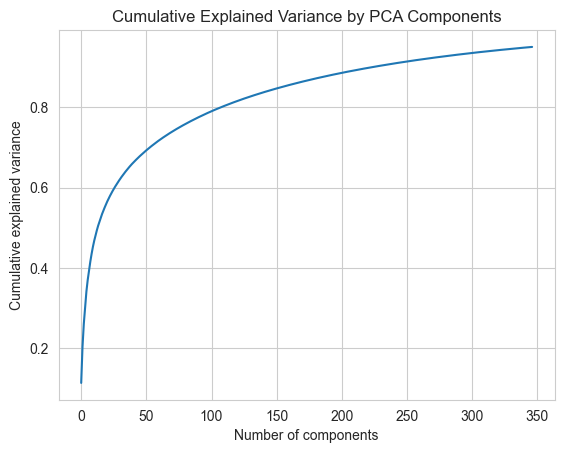

In [84]:
night_start_hour = 17  # Assuming night starts at 17:00
analyser = NightClustering(df=df_variables, feature_settings='efficient', night_start_hour=night_start_hour)
night_features = analyser.extract_night_level_features()

# Preprocess Night-Level Features (Scale and PCA)
pca_features = analyser.preprocess_night_features(n_components=0.95)
print("\nPreprocessed PCA features for nights:")
print(pca_features[:5])

# Plot the cumulative explained variance to help decide on the number of components
analyser.plot_pca_cumulative_variance()

The number of features that are selected automatically do not help interpretability, which is important to understanding the patterns behind the clusters. Also, given the significant number of features this produces and (even after PCA we reduce to 299 to cover 95% of variance) the elbow curve doesn't have sufficient definition to determine the optimal number of components.

As a baseline for comparison, we establish the silhouette scores for each n_cluster in a range of [2, 8]. The Silhouette Coefficient is a measure of how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The silhouette score ranges from -1 to 1, where a score close to 1 indicates that the object is well clustered, a score close to 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters, and a negative score indicates that the object may have been assigned to the wrong cluster.

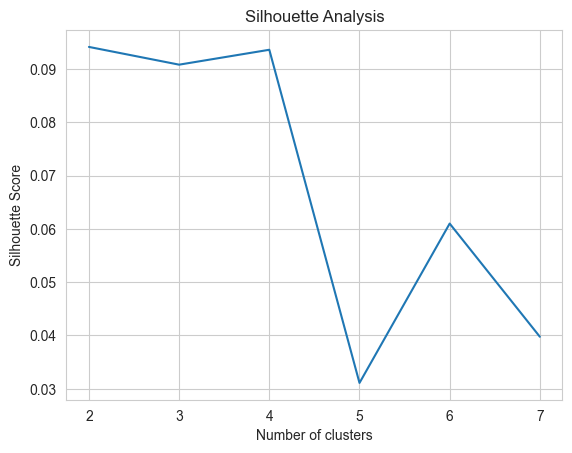

In [85]:
cluster_range = range(2,8)
baseline_silhoutte_scores = analyser.silhouette_analysis(cluster_range)

## Experiment 2: Custom Feature Extraction
Given the significant number of features and components result from the PCA analysis, it makes better sense to limit the features extracted to those that have meaning in interpretation and relevance to the clustering. The following uses the custom features extracted from the data based on knowledge of the patterns we want to identify in the night periods. This will allow us to see how well the clustering works with a smaller set of custom features that are more interpretable and relevant to the patterns we want to identify.

Feature Extraction: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Extracted 78 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
<class 'numpy.ndarray'>
Dropped features from scaling: {'iob max__count_above__t_100', 'cob max__minimum', 'cob mean__minimum'}
PCA reduced dimensions from 75 to 23.


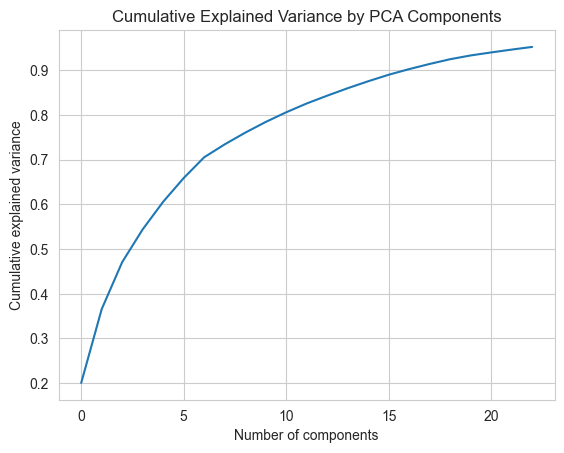

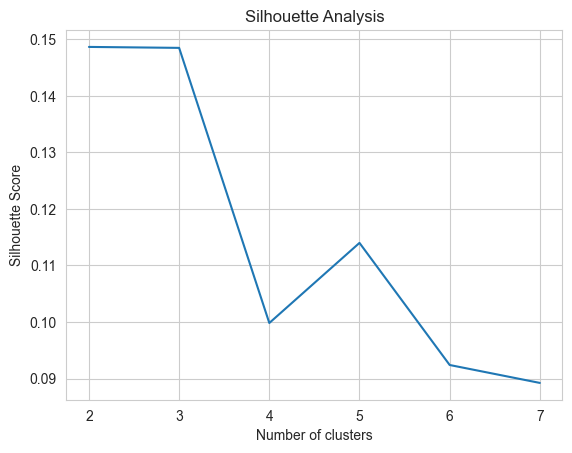

In [131]:
analyser = NightClustering(df=df_variables, feature_settings='custom', night_start_hour=night_start_hour)
night_features = analyser.extract_night_level_features()
pca_features = analyser.preprocess_night_features(n_components=0.95)
analyser.plot_pca_cumulative_variance()
custom_silhouette_scores = analyser.silhouette_analysis(cluster_range)

This is poor range of silhoutte scores and the decreasing score as the number grows intimates that there is little distinction that can be drawn in the clustering analysis. It is not significantly different to the baseline and with notably less features. The custom features are not providing a significant improvement over the efficient features, but they are more interpretable and relevant to the patterns we want to identify. This is a good baseline for the feature extraction process and allows us to see how well the clustering works if we limit the number of components to 2, which is a more manageable number of features to work with and interpret, plus easily visualised in 2D.

Preprocessing night-level features (scaling and PCA)...
<class 'numpy.ndarray'>
Dropped features from scaling: {'iob max__count_above__t_100', 'cob max__minimum', 'cob mean__minimum'}
PCA reduced dimensions from 75 to 2.
Explained variance: [0.20065463 0.16491781]


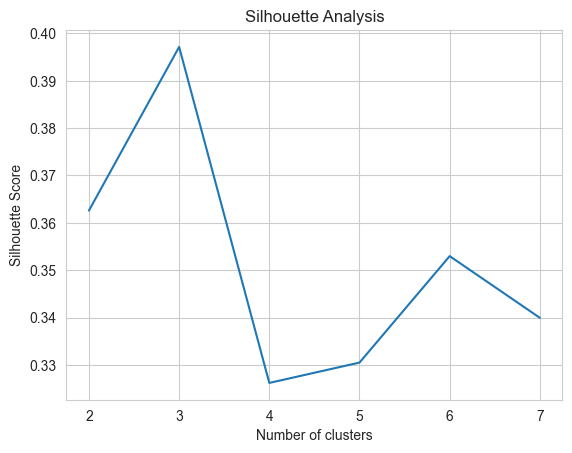

In [132]:
pca_features = analyser.preprocess_night_features(n_components=2)
print(f'Explained variance: {analyser.pca_model.explained_variance_ratio_}')
pca_silhouette_scores = analyser.silhouette_analysis(cluster_range)

Now we have a better silhouette score for 3 clusters, which is a good indication that the clustering is working well. We can now look at the clusters and see how they differ from each other. Let visualise them first, which is easier to do with two components.

Night cluster distribution:
(array([0, 1, 2], dtype=int32), array([202, 483, 237]))


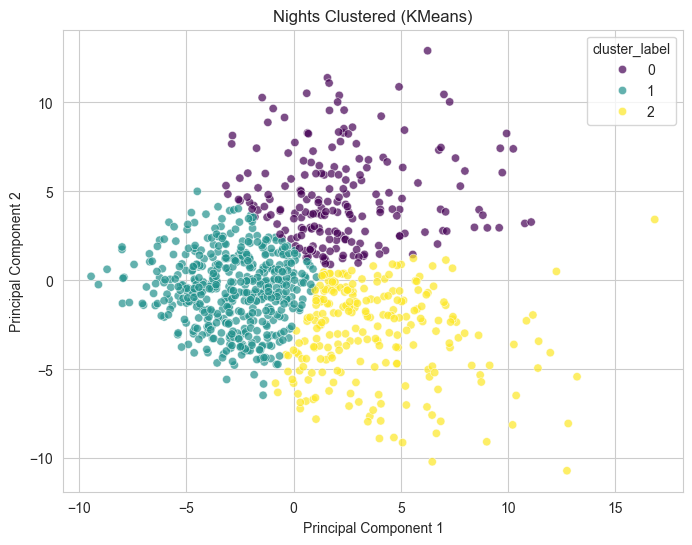

In [133]:
night_clusters = analyser.cluster_nights(n_clusters=3)

The clusters are not perfectly separated and distinction between them isn't clear, as the silhoutte scores would suggest. It is not presently clear why the clustering is showing this pattern, to we need to analyse the clusters further to understand the patterns.

## Cluster Analysis: Centroid Analysis
Now we have established the clusters, we can look at the centroids of each cluster to see what the average feature values are for each cluster. This will help us understand the patterns in the night periods and how they differ between clusters.

In [134]:
# Get characteristics of clusters
cluster_centroids = analyser.get_cluster_centroids()
print("\nCluster Centroids (mean feature values in original scale):")
cluster_centroids.T


Cluster Centroids (mean feature values in original scale):


cluster_label,0,1,2
iob mean__mean,2.263603,0.744394,1.952271
iob mean__variance,9.233348,1.632495,5.396993
iob mean__maximum,9.750460,3.711263,7.339498
iob mean__minimum,-0.541277,-0.728913,-0.404713
iob mean__median,1.265765,0.465562,1.365515
...,...,...,...
iob max__root_mean_square,3.988789,1.544976,3.108363
iob max__first_location_of_maximum,0.256220,0.402008,0.292901
iob max__last_location_of_maximum,0.284382,0.430155,0.321097
iob max__first_location_of_minimum,0.589753,0.490146,0.563656


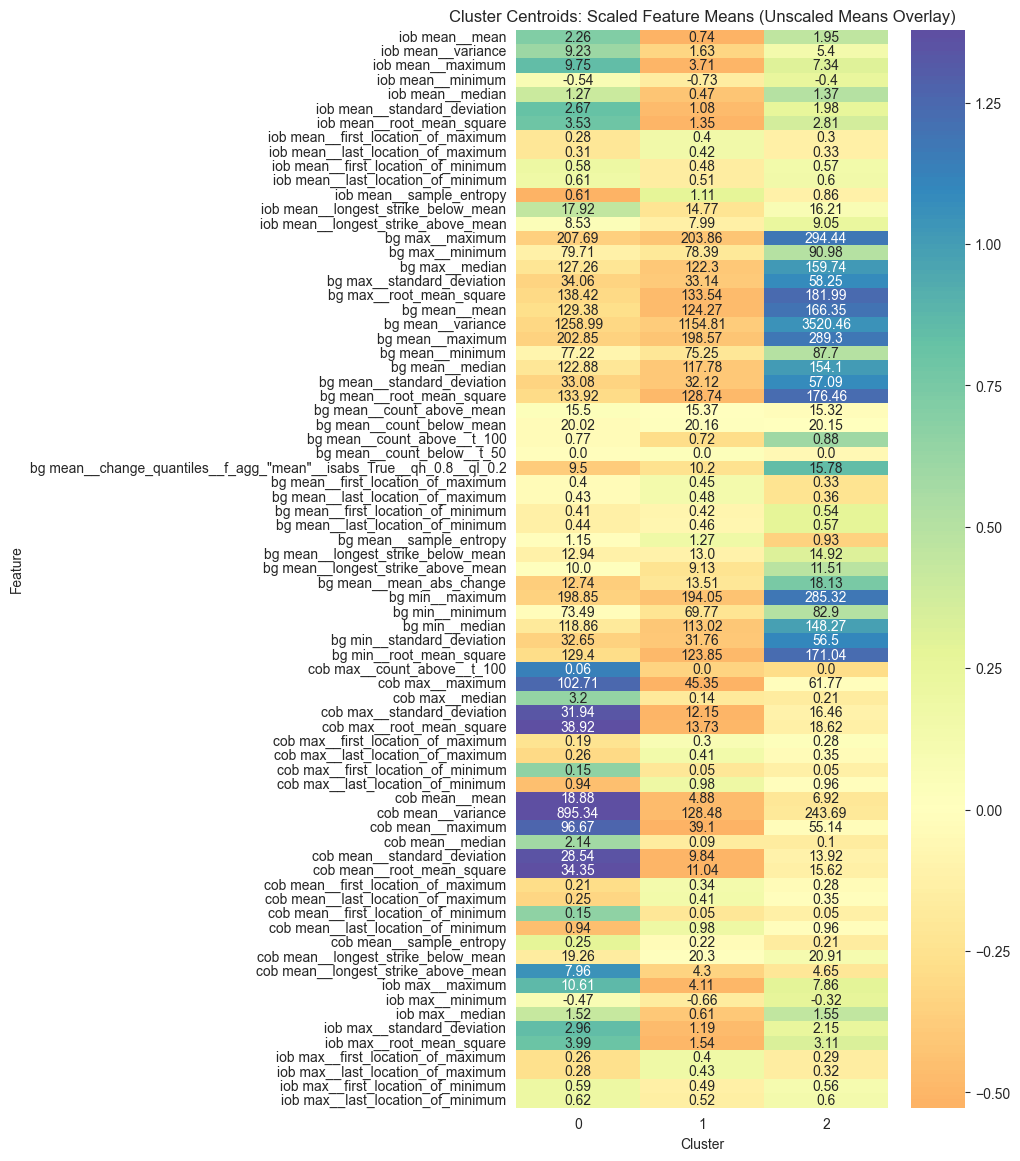

In [135]:
analyser.heatmap_cluster_features()

The heatmap highlights the differences between the clusters, using still scaled values to allow comparison. The largest cluster (cluster 0 at n=510) has relatively low levels of BG and low levels of IOB and COB and low levels of variance in these. Cluster 1 (n=280) sees BG at low to 'standard' levels and higher levels of COB and variance, with higher maxima, but IOB relatively stable with, with low variance. Cluster 2 (n=132) has higher levels of BG, later maximums for BG and IOB variables and low variance as well. This suggests that cluster 2 is a cluster of nights with high levels of activity, cluster 0 is a cluster of nights with low levels of activity, and cluster 1 is a cluster of nights with more stable BG, high levels of COB but stable insulin. This is a good indication that the clustering is working well and that the features are providing useful information about the patterns in the night periods, but we don't yet know how to interpret these clusters in terms of the underlying states of the patients during these periods. We need to look at the individual nights in each cluster to see how they differ from each other and what patterns they exhibit. We'll fist look at the distribution of the clusters to see how they are distributed across the patients.

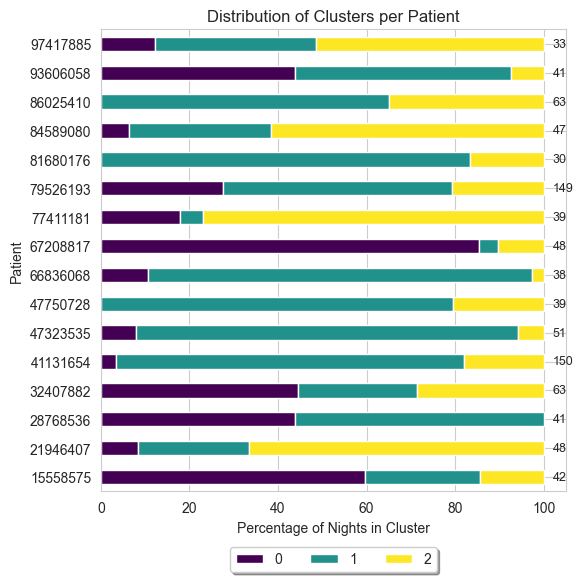

In [136]:
analyser.plot_cluster_distribution()

The picture is mixed, but shows a clear bias of distributions to single clusters for some patients, which will be due to the clustering. We can measure put some metrics to these distributions using Entropy and Gini Coefficient, which will help us understand the diversity of clusters for each patient. The Entropy is a measure of the uncertainty or randomness in a distribution, while the Gini Coefficient is a measure of inequality in a distribution. A higher Entropy indicates a more diverse distribution, while a lower Gini Coefficient indicates a more equal distribution.

In [137]:
entropy = analyser.calculate_distribution_metrics()

Mean entropy of cluster distribution per patient: 0.959
Normalised mean entropy of cluster distribution per patient: 0.605
Mean Gini coefficient of cluster distribution per patient: 0.402


The values show that the distribution of clusters is similar to how we have observed in the bar chart, with some patients having a more diverse distribution of clusters than others, resulting in Gini scores showing neither equality or inequality, and entropy scores showing a moderate level of diversity.

### Applying t-SNE for clustering

Plotting t-SNE with original clusters


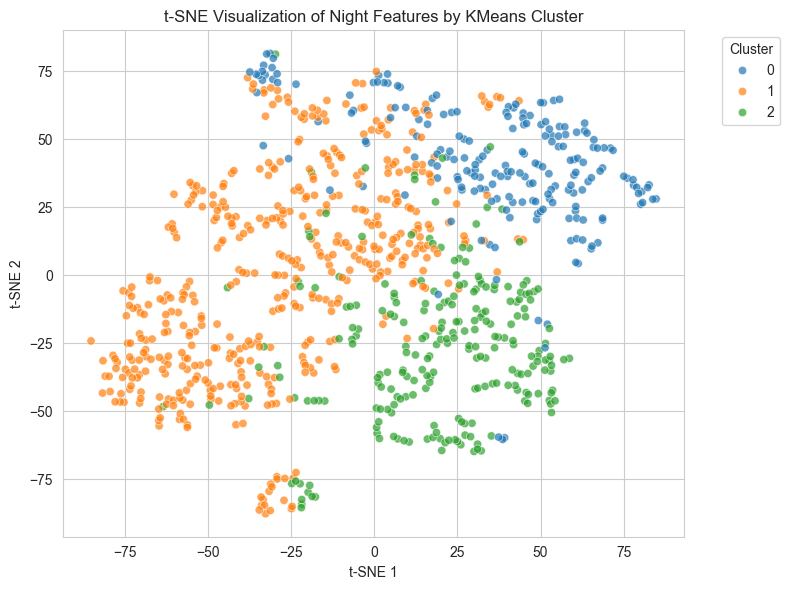

In [153]:
print('Plotting t-SNE with original clusters')
kwargs = {'perplexity': 10, 'max_iter': 80000}
analyser.fit_tsne(**kwargs)
analyser.plot_tsne(cluster_type='kmeans')

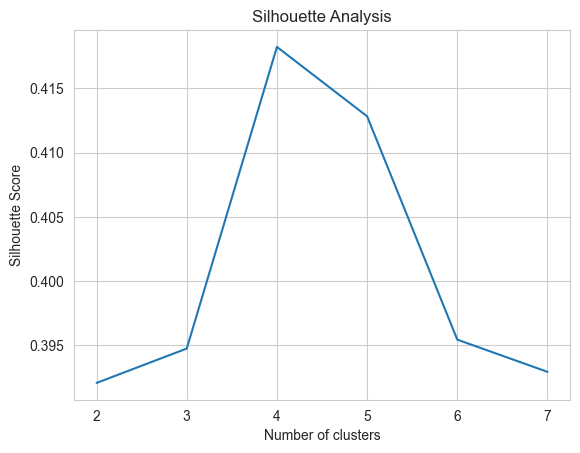

In [154]:
cluster_range = range(2, 8)
tsne_silhouette_scores = analyser.silhouette_analysis(cluster_range=cluster_range, cluster_type='tsne', **kwargs)

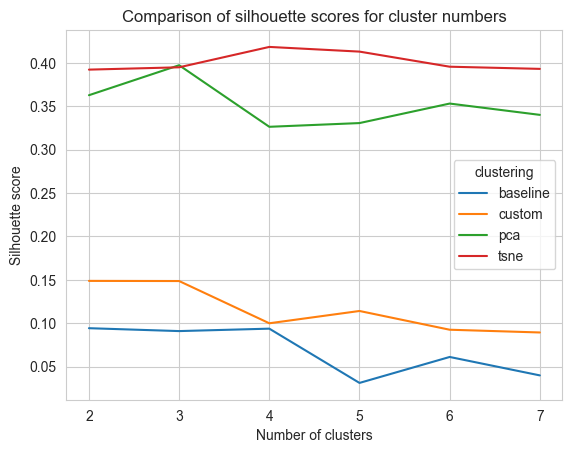

In [155]:
# Comparison of silhouette scores for the models
data = {'n_clusters': cluster_range,
        'baseline': baseline_silhoutte_scores,
        'custom': custom_silhouette_scores,
        'pca': pca_silhouette_scores,
        'tsne': tsne_silhouette_scores,}
silhouette_df = pd.DataFrame(data).melt(id_vars='n_clusters', var_name='clustering', value_name='score')

sns.lineplot(data=silhouette_df, x='n_clusters', y='score', hue='clustering')
plt.title('Comparison of silhouette scores for cluster numbers')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

From the plots above, it shows that there is generally better definition in the clusters from the t-SNE components. Looking at the heatmap also produced below

Max silhouette score:  0.42 for 4 clusters


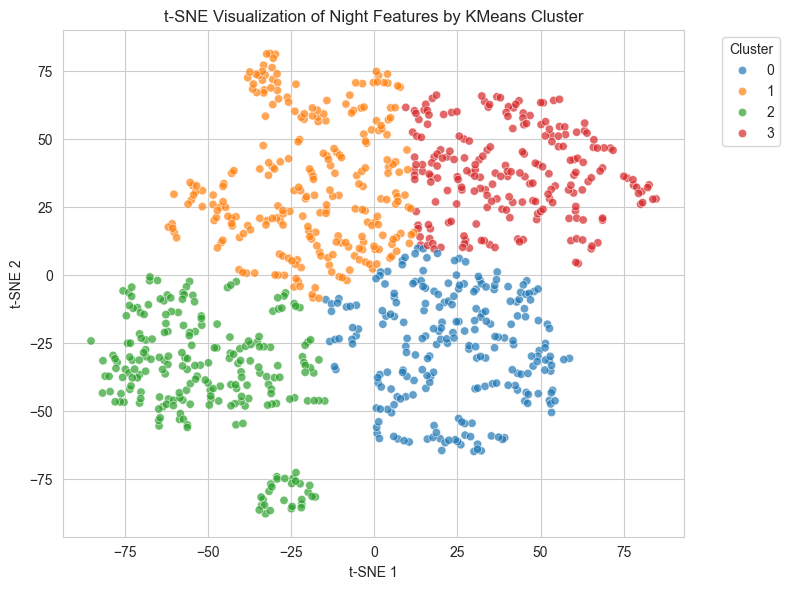

In [156]:
max_score = max(tsne_silhouette_scores)
idx = tsne_silhouette_scores.index(max_score)
n_clusters = list(cluster_range)[idx]
print(f'Max silhouette score: {max_score: .2f} for {n_clusters} clusters')
analyser.clustering_tsne(n_clusters=n_clusters)
analyser.plot_tsne(cluster_type='tsne')

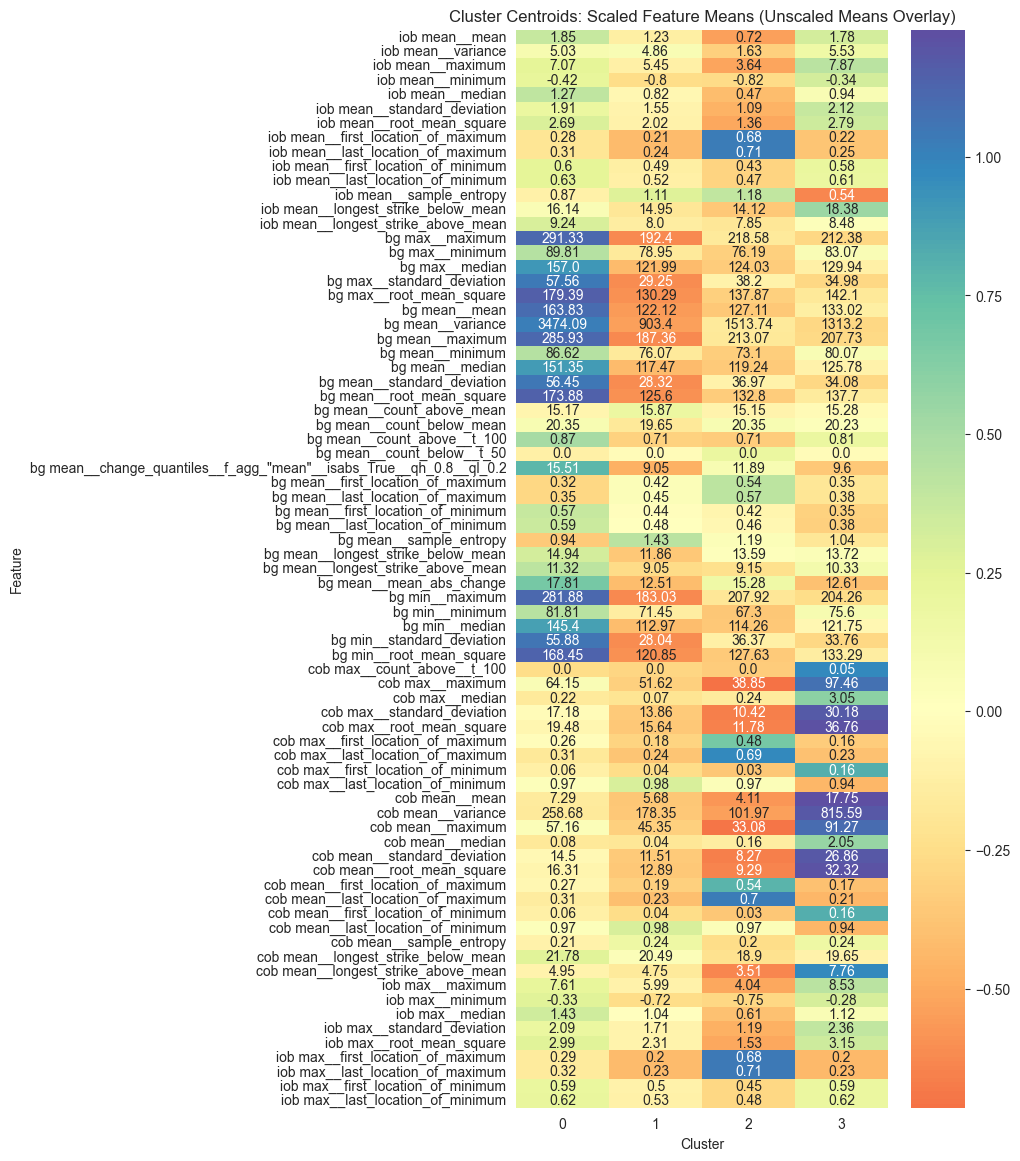

In [157]:
analyser.heatmap_cluster_features(cluster_type='tsne')

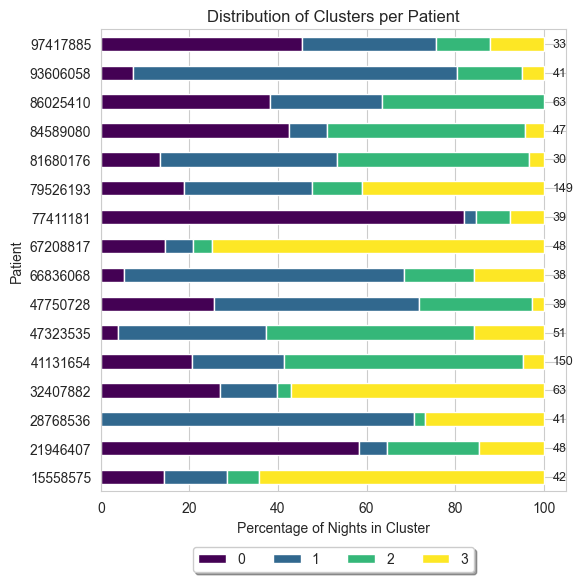

In [158]:
analyser.plot_cluster_distribution(cluster_type='tsne')

In [159]:
entropy = analyser.calculate_distribution_metrics(cluster_type='tsne')
night_counts = analyser.get_summary_statistics()

Mean entropy of cluster distribution per patient: 1.221
Normalised mean entropy of cluster distribution per patient: 0.611
Mean Gini coefficient of cluster distribution per patient: 0.416


As could be anticipated, the entropy and Gini coefficient scores are improved, given the more clusters and distribution observed.

## Analysis of individuals - min/mid/max entropy
The following will now look at the three selected individuals and their night profiles to see if we can observe any differences between them. Individuals with min, mid and max entropy score are taken to see how their distributions look when plotted.

In [160]:
max_id = entropy.idxmax()
min_id = entropy.idxmin()
sorted_series = entropy.sort_values()
mid_id = sorted_series.index[len(sorted_series) // 2]

In [161]:
print('Night counts for each of the subjects:')
print(f'\tmin entropy: {entropy[min_id]:.2f}, nights: {night_counts.loc[min_id, "nights"]}')
print(f'\tmid entropy: {entropy[mid_id]:.2f}, nights: {night_counts.loc[mid_id, "nights"]}')
print(f'\tmax entropy: {entropy[max_id]:.2f}, nights: {night_counts.loc[max_id, "nights"]}')

Night counts for each of the subjects:
	min entropy: 0.45, nights: 39
	mid entropy: 0.59, nights: 39
	max entropy: 0.95, nights: 149


As a quick reminder of their distributions...

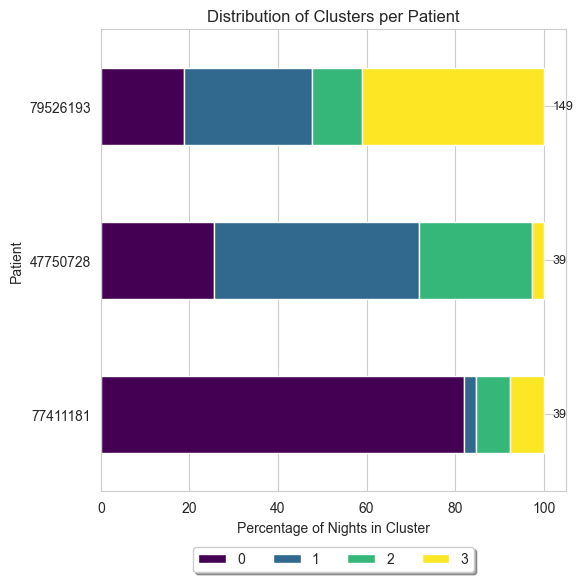

In [162]:
ids = [min_id, mid_id, max_id]
pivot_counts_tsne = analyser.get_cluster_distributions(cluster_type='tsne')
analyser.plot_cluster_distribution(pivot_counts_tsne.loc[ids])

Night profiles: 39


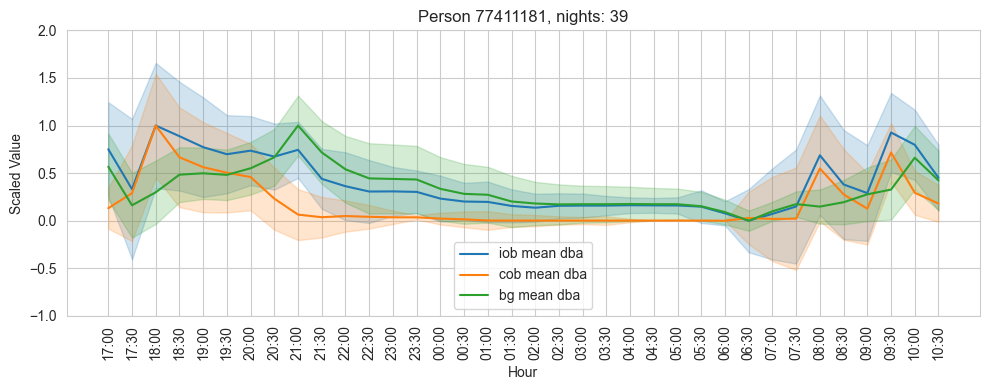

Night profiles: 39


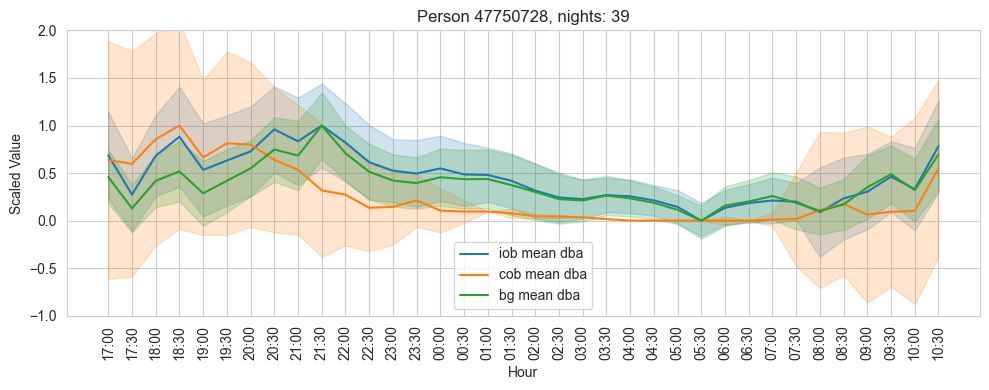

Night profiles: 149


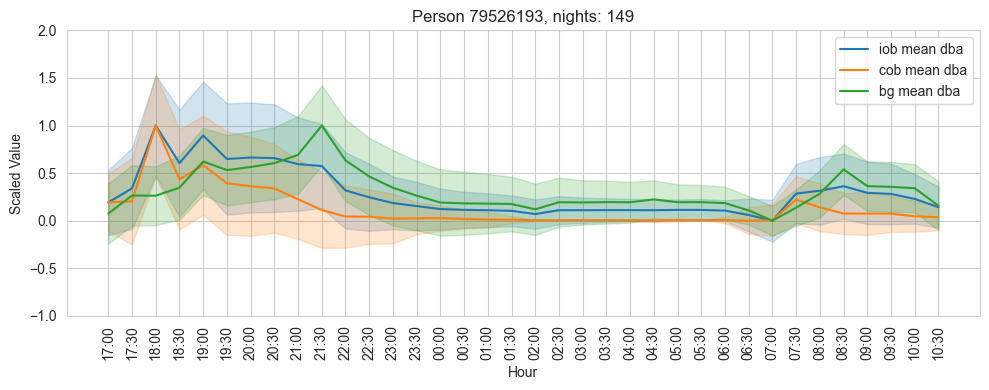

In [255]:
df = analyser.return_dataset_with_clusters()

morning_end_hour = 11

for id_ in ids:
    plot_night_time_series(df.xs(key=id_, level='id', drop_level=False), zip_id=id_, night_start=night_start_hour, morning_end=morning_end.hour, method='dba', y_limits=(-1, 2))

There is nothing in these profiles that gives any more information as to the impact of the equality of distribution. The next comparison that would be sensible is to select two groups and compare these statistically to see the differences between the two.

### Comparison of clusters
Another way we might compare these is to look comparisons of different clusters. The following will average profiles for the different clusters to observe how the different traits visible in the clusters look like in the profiles. We'll first compare the two clusters with the most and least significant variance in BG levels and see if there are patterns in the data.

Profile for cluster label: 0
Night profiles: 229


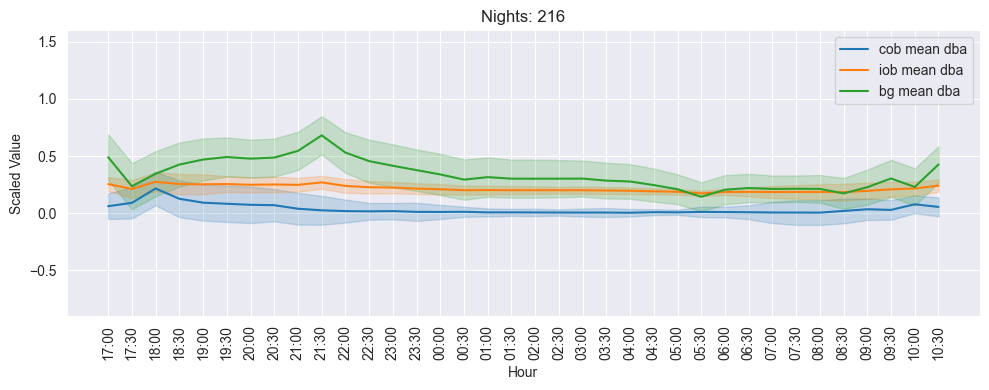

Profile for cluster label: 1
Night profiles: 255


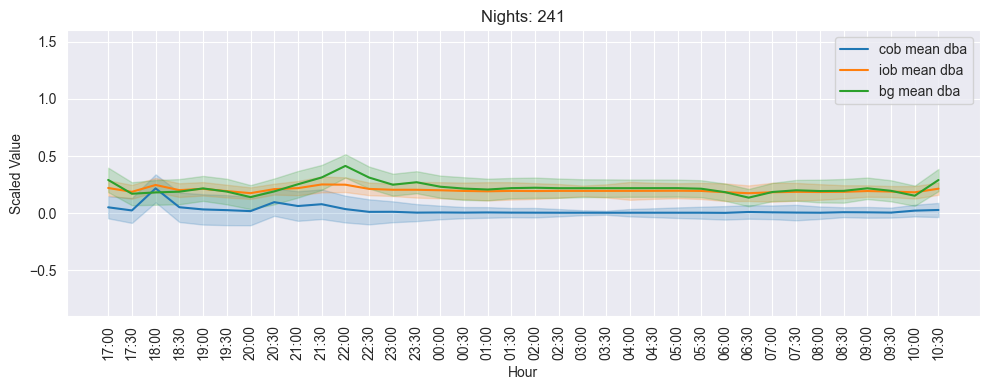

Profile for cluster label: 2
Night profiles: 226


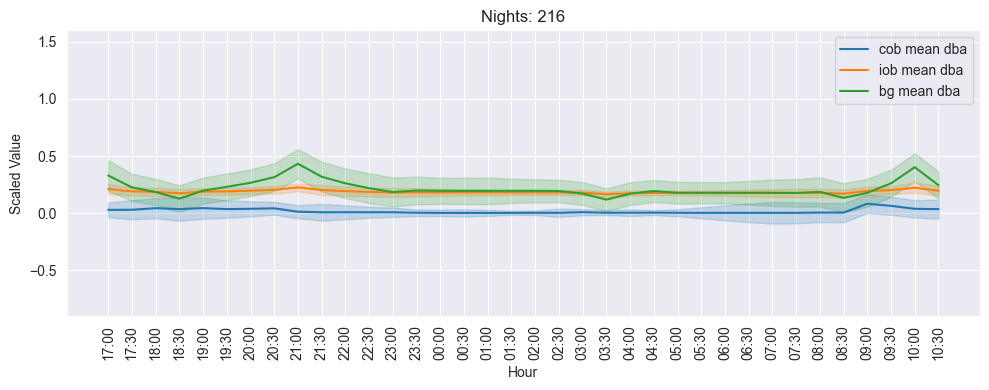

Profile for cluster label: 3
Night profiles: 212


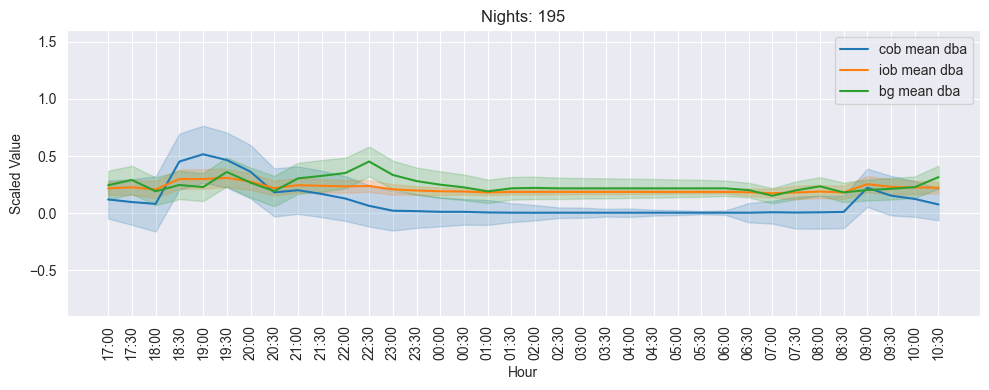

In [263]:
variables = ['cob mean', 'iob mean', 'bg mean']
global_min = df[variables].min()
global_max = df[variables].max()
cluster_ids = sorted(df['tsne_cluster_label'].unique())
cluster_dfs = {}
for c in cluster_ids:
    cluster_dfs[c] = analyser.get_cluster_nights(cluster_type='tsne', cluster_label=c)
for key, df_c in cluster_dfs.items():
    print(f'Profile for cluster label: {str(key)}')
    plot_night_time_series(df_c, variables=variables, global_min=global_min, global_max=global_max, night_start=night_start.hour, morning_end=morning_end.hour, method='dba', y_limits=(-0.9, 1.6), )

These 4 cluster profiles are certainly showing different traits. The most notable of the observable characteristics are:
-

Lets analyse some statistics behind them before we delve deeper.

In [ ]:
for c in cluster_ids:
    cluster_dfs[c] = analyser.get_cluster_nights(cluster_type='tsne', cluster_label=c)
for key, df_c in cluster_dfs.items():
    print(f'Profile for cluster label: {str(key)}')
    plot_night_time_series(df_c, variables=variables, global_min=global_min, global_max=global_max, night_start=night_start.hour, morning_end=morning_end.hour, method='dba', y_limits=(-0.9, 1.6))

In [266]:
scaled_all_df = analyser.return_dataset_with_clusters(scaled=True)

                           index            datetime  bg mean  bg min  bg max  \
id       night_start_date                                                       
15558575 2018-04-17            0 2018-04-17 17:00:00    145.5   127.0   159.0   
         2018-04-17            1 2018-04-17 17:30:00     97.5    93.0   102.0   
         2018-04-17            2 2018-04-17 18:00:00     71.5    66.0    77.0   
         2018-04-17            3 2018-04-17 18:30:00     76.0    76.0    76.0   
         2018-04-17            4 2018-04-17 19:00:00    110.0   110.0   110.0   

                           iob mean  iob max  cob mean  cob max  
id       night_start_date                                        
15558575 2018-04-17           2.609    7.776     16.25     65.0  
         2018-04-17           6.045    6.425     58.50     59.0  
         2018-04-17           4.101    4.825     49.00     52.0  
         2018-04-17           1.623    1.623     51.00     51.0  
         2018-04-17           1.869 

Profile for cluster label: 0
Night profiles: 229


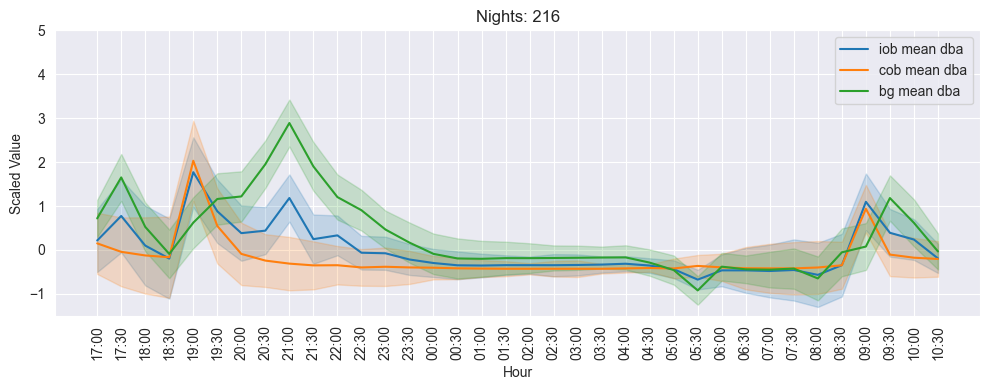

Profile for cluster label: 1
Night profiles: 255


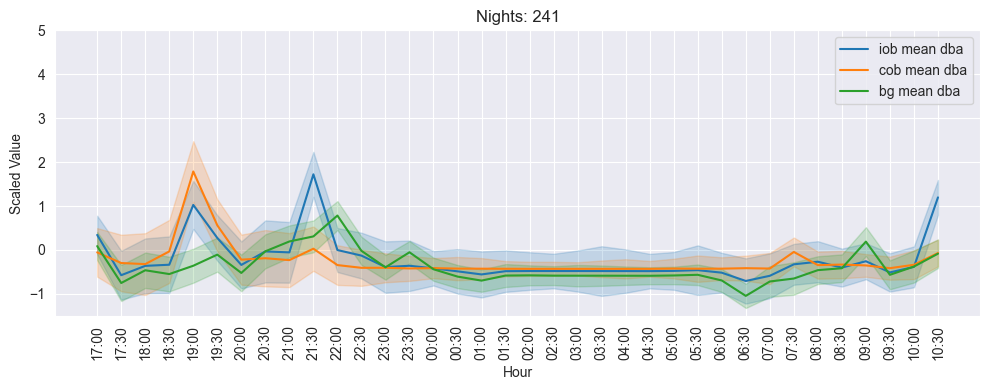

Profile for cluster label: 2
Night profiles: 226


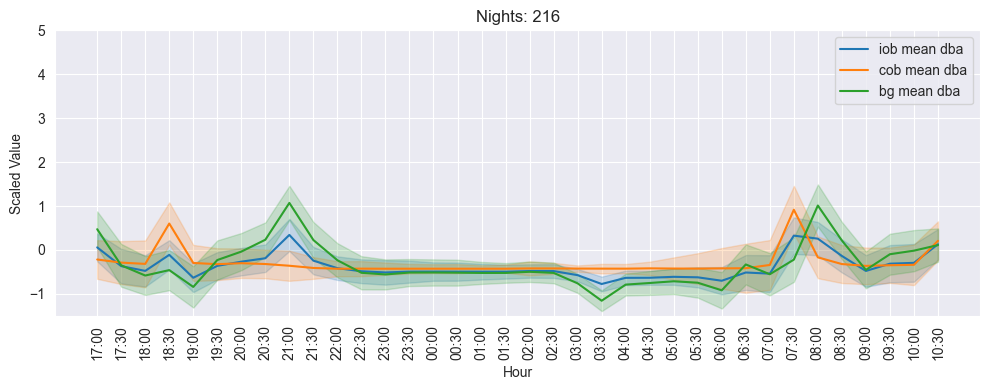

Profile for cluster label: 3
Night profiles: 212


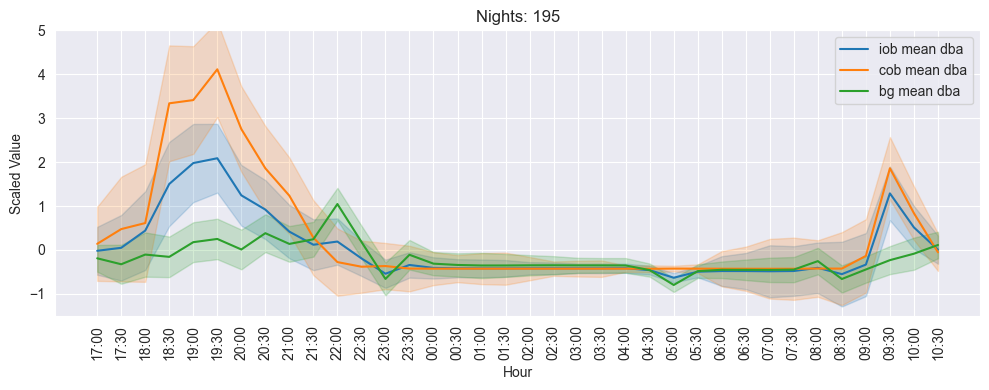

In [278]:
for cluster, df_cluster in scaled_all_df.groupby('tsne_cluster_label'):
    print(f'Profile for cluster label: {str(cluster)}')
    plot_night_time_series(df_cluster, night_start=night_start.hour, morning_end=morning_end.hour, method='dba', rolling_window=3, y_limits=(-1.5, 5), )

Its still not entirely clear that these peaks are not caused by specific individuals, however. These profiles will be biased toward the behaviour of individuals with the highest number of nights in the cluster sample.

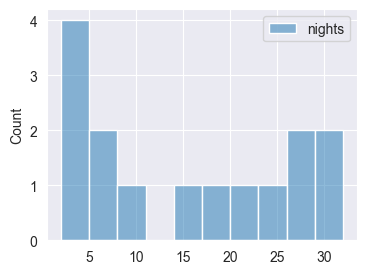

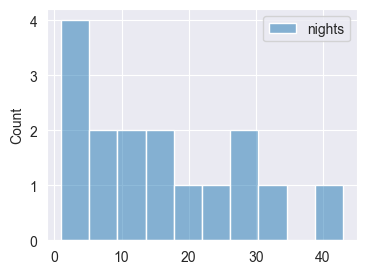

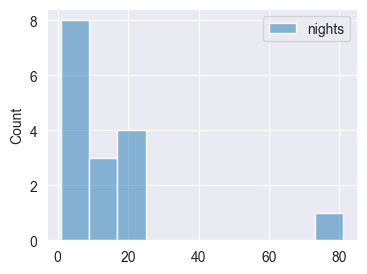

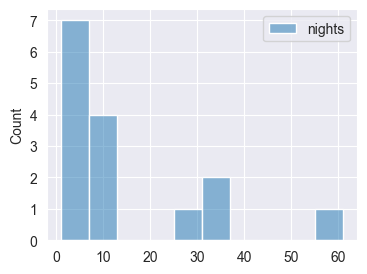

In [295]:
hist_data = (scaled_all_df.
             reset_index()[['id','night_start_date','tsne_cluster_label']].
             drop_duplicates().
             groupby(['id','tsne_cluster_label']).
             agg(nights=('night_start_date', 'size')
))

for c, df_hist in hist_data.groupby('tsne_cluster_label'):
    plt.figure(figsize=(4, 3))
    sns.histplot(df_hist, bins=10)
    plt.show()

